<a href="https://colab.research.google.com/github/sreeja-01p/Diabetic-Retinopathy/blob/main/dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_csv ='/content/drive/MyDrive/dataset/train.csv'
train_image_dir ='/content/drive/MyDrive/dataset/train_images'

In [4]:
test_csv = '/content/drive/MyDrive/dataset/test.csv'
test_image_dir ='/content/drive/MyDrive/dataset/test_images'

In [31]:
class DRDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.dataframe.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1] if 'diagnosis' in self.dataframe.columns else -1

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
trainLabels = pd.read_csv(train_csv)
print(trainLabels.head())

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [9]:
testLabels = pd.read_csv(test_csv)
print(testLabels.head())

        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


In [10]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
train_df, val_df = train_test_split(trainLabels, train_size=0.8, shuffle=True, random_state=1)

In [12]:
print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(testLabels)}")

Train samples: 2929, Validation samples: 733, Test samples: 1928


In [13]:
train_dataset = DRDataset(train_df, train_image_dir, transform=data_transforms)
val_dataset = DRDataset(val_df, train_image_dir, transform=data_transforms)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [32]:
test_dataset = DRDataset(testLabels, test_image_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
print(trainLabels.columns)
print(trainLabels.head())

Index(['id_code', 'diagnosis'], dtype='object')
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


<ipython-input-16-ef0e94c76488>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc, palette="rocket")


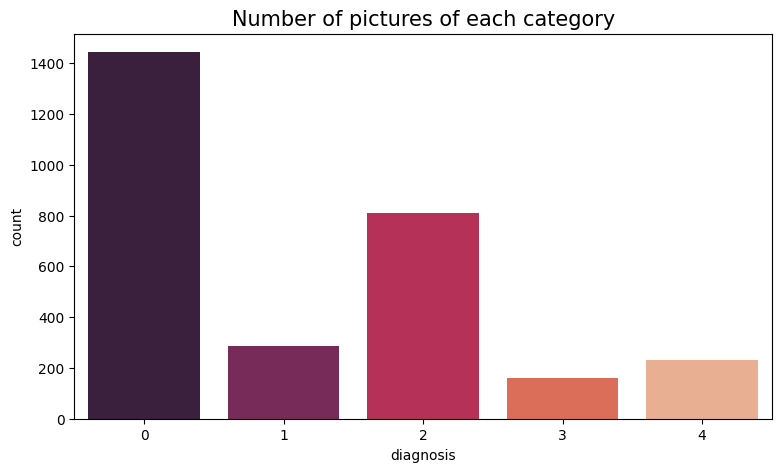

In [16]:
vc = train_df['diagnosis'].value_counts()
plt.figure(figsize=(9, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=15)
plt.show()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  #Freeze pretrained layers

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
num_classes = trainLabels['diagnosis'].nunique()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [21]:
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    #training
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    #validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Acc: {val_accs[-1]:.4f}")

Epoch 1/10: 100%|██████████| 92/92 [39:10<00:00, 25.55s/it]


Epoch 1/10, Train Loss: 0.9128, Train Acc: 0.6787, Val Loss: 0.6944, Val Acc: 0.7544


Epoch 2/10: 100%|██████████| 92/92 [24:29<00:00, 15.97s/it]


Epoch 2/10, Train Loss: 0.7374, Train Acc: 0.7340, Val Loss: 0.6384, Val Acc: 0.7503


Epoch 3/10: 100%|██████████| 92/92 [24:45<00:00, 16.15s/it]


Epoch 3/10, Train Loss: 0.6929, Train Acc: 0.7354, Val Loss: 0.6982, Val Acc: 0.7203


Epoch 4/10: 100%|██████████| 92/92 [24:38<00:00, 16.08s/it]


Epoch 4/10, Train Loss: 0.6911, Train Acc: 0.7368, Val Loss: 0.6059, Val Acc: 0.7531


Epoch 5/10: 100%|██████████| 92/92 [24:44<00:00, 16.14s/it]


Epoch 5/10, Train Loss: 0.6557, Train Acc: 0.7552, Val Loss: 0.6121, Val Acc: 0.7449


Epoch 6/10: 100%|██████████| 92/92 [24:20<00:00, 15.88s/it]


Epoch 6/10, Train Loss: 0.6825, Train Acc: 0.7409, Val Loss: 0.5776, Val Acc: 0.7626


Epoch 7/10: 100%|██████████| 92/92 [24:36<00:00, 16.05s/it]


Epoch 7/10, Train Loss: 0.6374, Train Acc: 0.7617, Val Loss: 0.5871, Val Acc: 0.7626


Epoch 8/10: 100%|██████████| 92/92 [24:59<00:00, 16.30s/it]


Epoch 8/10, Train Loss: 0.6189, Train Acc: 0.7644, Val Loss: 0.5731, Val Acc: 0.7694


Epoch 9/10: 100%|██████████| 92/92 [25:25<00:00, 16.58s/it]


Epoch 9/10, Train Loss: 0.6505, Train Acc: 0.7603, Val Loss: 0.6021, Val Acc: 0.7585


Epoch 10/10: 100%|██████████| 92/92 [25:11<00:00, 16.43s/it]


Epoch 10/10, Train Loss: 0.6352, Train Acc: 0.7624, Val Loss: 0.5674, Val Acc: 0.7653


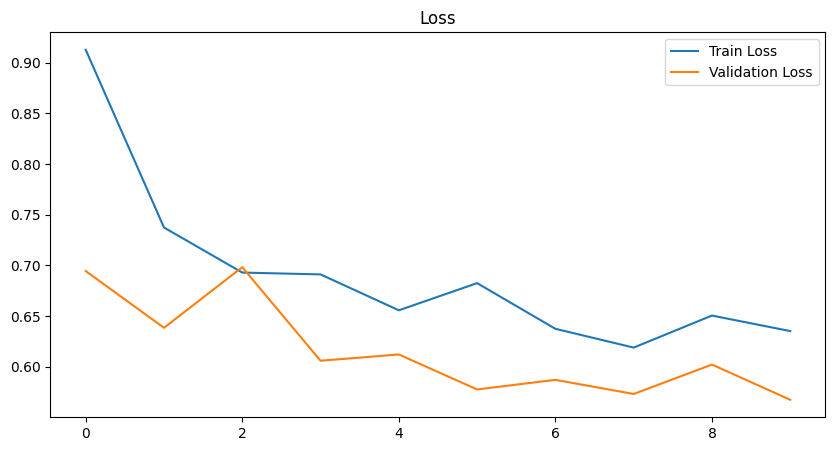

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

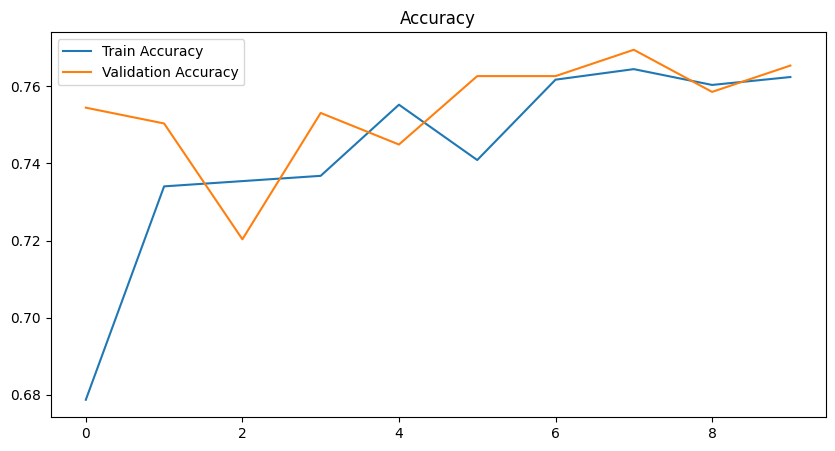

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

testing

In [34]:
model.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

print("Predictions for test set:", predictions[:10])

Predictions for test set: [1, 2, 2, 2, 2, 2, 2, 0, 2, 1]
